In [ ]:
!pip install tensorflow

In [ ]:
pip install --upgrade "jax[cuda]"

In [1]:
%load_ext autoreload
%autoreload 2

## Testing polynomial trajectory generation

(101, 3)


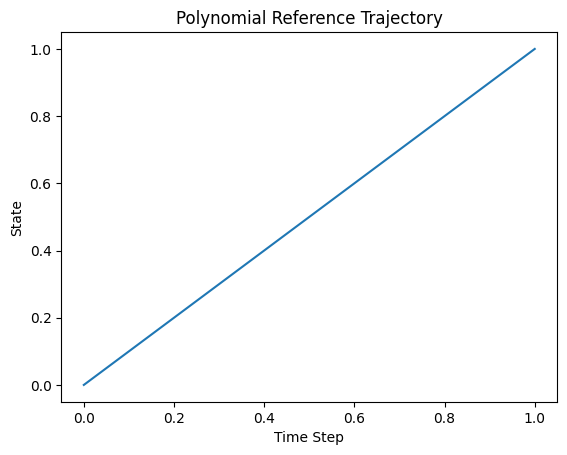

In [8]:
from generate_data import generate_polynomial_trajectory
import numpy as np
import matplotlib.pyplot as plt

start = np.zeros(3)
end = np.ones(3)
T = 101
order = 2

trajectory = generate_polynomial_trajectory(start, end, T, order)

print(trajectory.shape)

# Plot the results
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.title('Polynomial Reference Trajectory')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

## Data generation

In [18]:
from generate_data import gen_uni_training_data, ILQR, unicycle, save_object, unicycle_K
import jax.numpy as onp

# F = np.array([[np.cos(theta), 0], [np.sin(theta), 0], [0, 1]])
# Kp = 5 * np.array([[2, 1, 0], [0, 1, 3]])
# Kd = np.linalg.pinv(F)

uni_ilqr1 = ILQR(unicycle_K, maxiter=1000)
num_iter = 5
xtraj, rtraj, rdottraj, costs = gen_uni_training_data(uni_ilqr1, num_iter, 6, 3)

# Save as pickle file
save_object([xtraj, rtraj, rdottraj, costs], 'data/uni_train-nonoise4.pkl')

[1.5028434 2.8508093 1.2693846 1.532851  2.4889758 1.0151589 2.221095
 1.5659196 2.4247885 1.4605057 0.        0.        0.        0.
 0.       ]
[[1.5028434 1.0151589 0.       ]
 [2.8508093 2.221095  0.       ]
 [1.2693846 1.5659196 0.       ]
 [1.532851  2.4247885 0.       ]
 [2.4889758 1.4605057 0.       ]]
[[0.80659175 0.3132937  2.1496344 ]
 [0.1277101  0.3776858  0.277409  ]
 [1.8226852  0.33794832 0.43242866]
 [1.3734641  1.8171492  2.5634775 ]
 [0.1745677  0.3679514  1.3324766 ]]
1
0.02950964
362612.25
3
0.3396194
30687.242
5
0.008901833
181716.45
7
0.029061684
442920.3
9
0.038086697
243769.31


## Load data

In [19]:
from helper_functions import compute_tracking_cost
from mlp_jax import MLP
from generate_data import load_object
from model_learning import TrajDataset, train_model, eval_model, numpy_collate, save_checkpoint, restore_checkpoint
import numpy as np


file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/uni_train-nonoise4.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
ref_traj = np.vstack(unicycle_data[1])
rdot_traj = np.vstack(unicycle_data[2])
print(actual_traj.shape)
print(ref_traj.shape)
print(rdot_traj.shape)

(1010, 3)
(1010, 3)
(1010, 3)


## Adding noise to trajectories

In [3]:
from helper_functions import forward_simulate, compute_rdot
import jax

noise_level = [0.001, 0.002, 0.003, 0.004]
num_iter = 50

Kp = 50 * np.array([[2, 0, 0], [0, 1, 0]])
key = jax.random.PRNGKey(793)
Kd = 50 * jax.random.uniform(key=key, shape=(2, 3))
N = 101

for i in range(len(noise_level)):
    for j in range(num_iter):
        noise = np.random.normal(0, noise_level[i], (N, 2))
        noisy_ref = np.zeros(shape=(N, 3))
        noisy_ref[:, 0] = ref_traj[j*N:(j+1)*N, 0] + noise[:, 0]
        noisy_ref[:, 1:3] = ref_traj[j*N:(j+1)*N, 1:3]
        ref_traj = np.vstack([ref_traj, noisy_ref])
        cost, act = forward_simulate(noisy_ref[0, :], noisy_ref, Kp, Kd, N)
        actual_traj = np.vstack([actual_traj, act])
        rdot = compute_rdot(noisy_ref, 0.01)
        rdot_traj = np.vstack([rdot_traj, rdot])

In [4]:
print(actual_traj.shape)
print(ref_traj.shape)
print(rdot_traj.shape)

(25250, 3)
(25250, 3)
(25250, 3)


## Look at trajectories

In [20]:
%matplotlib notebook

In [5]:
def animate(i):
    line.set_ydata(actual_traj[i, 1])  # update the data.
    return line,

<IPython.core.display.Javascript object>


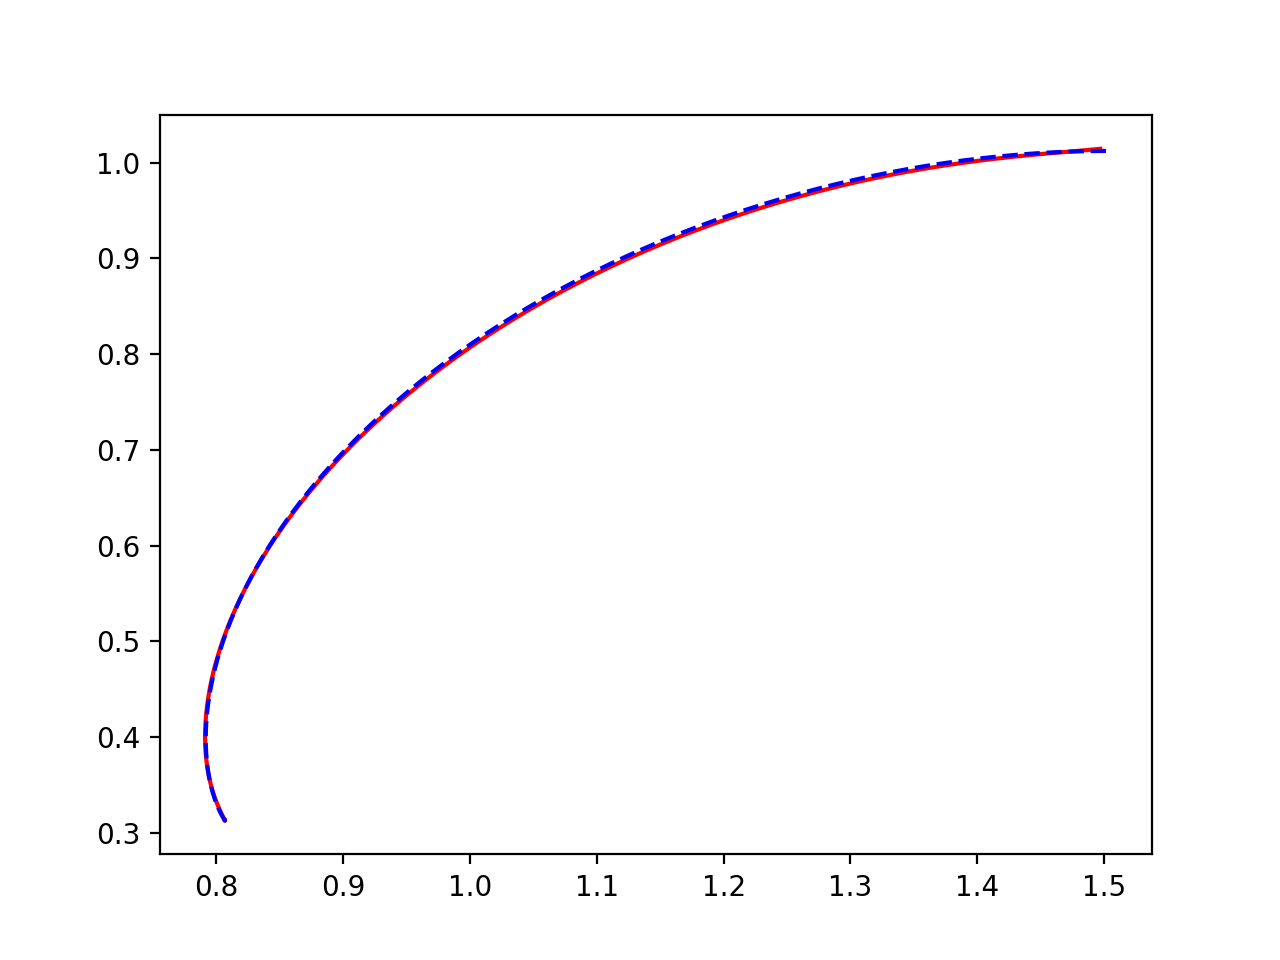

In [21]:
import matplotlib.pyplot as plt

plt.figure()
Tstart = 0
Tend = 101

plt.plot(ref_traj[Tstart:Tend, 0], ref_traj[Tstart:Tend, 1], 'r-', 
         actual_traj[Tstart:Tend, 0], actual_traj[Tstart:Tend, 1], 'b--')

In [ ]:
plt.figure()
Tstart = 0
Tend = 6006
plt.plot(ref_traj[Tstart:Tend, 2], 'r-', 
         actual_traj[Tstart:Tend, 2], 'b--')

## Prepare data with augmented states and compute cost

In [22]:
import jax

N = 5
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]
horizon = 101
#num_iter = int(traj_len/horizon)
num_iter = 1

# ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
# actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])

# Kp = 50 * np.array([[2, 0, 0], [0, 1, 0]])
Kp = 5 * np.array([[2, 1, 0], [0, 1, 3]])
# key = jax.random.PRNGKey(793)
# Kd = 50 * jax.random.uniform(key=key, shape=(2, 3))

cost_traj, input_traj = compute_tracking_cost(ref_traj, actual_traj, rdot_traj, Kp, N, horizon, 100)

aug_state = []
for i in range(num_iter):
    r0 = ref_traj[i*horizon:(i+1)*horizon, :]
    r0 = np.append(r0, r0[-1, :] * np.ones((N-1, 3)))
    r0 = np.reshape(r0, (horizon+N-1, 3))
    for j in range(horizon-N):
        aug_state.append(np.append(actual_traj[j, :], r0[j:j+N, :]))
# aug_state = [np.append(actual_traj[r, :], ref_traj[r:r+N, :]) for r in range(num_iter)]
aug_state = np.array(aug_state)
print(aug_state.shape)

Tstart=0
Tend=aug_state.shape[0]

dataset = TrajDataset(aug_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_state[Tstart+1:Tend, :].astype('float64'))

1010
(96, 18)


<IPython.core.display.Javascript object>


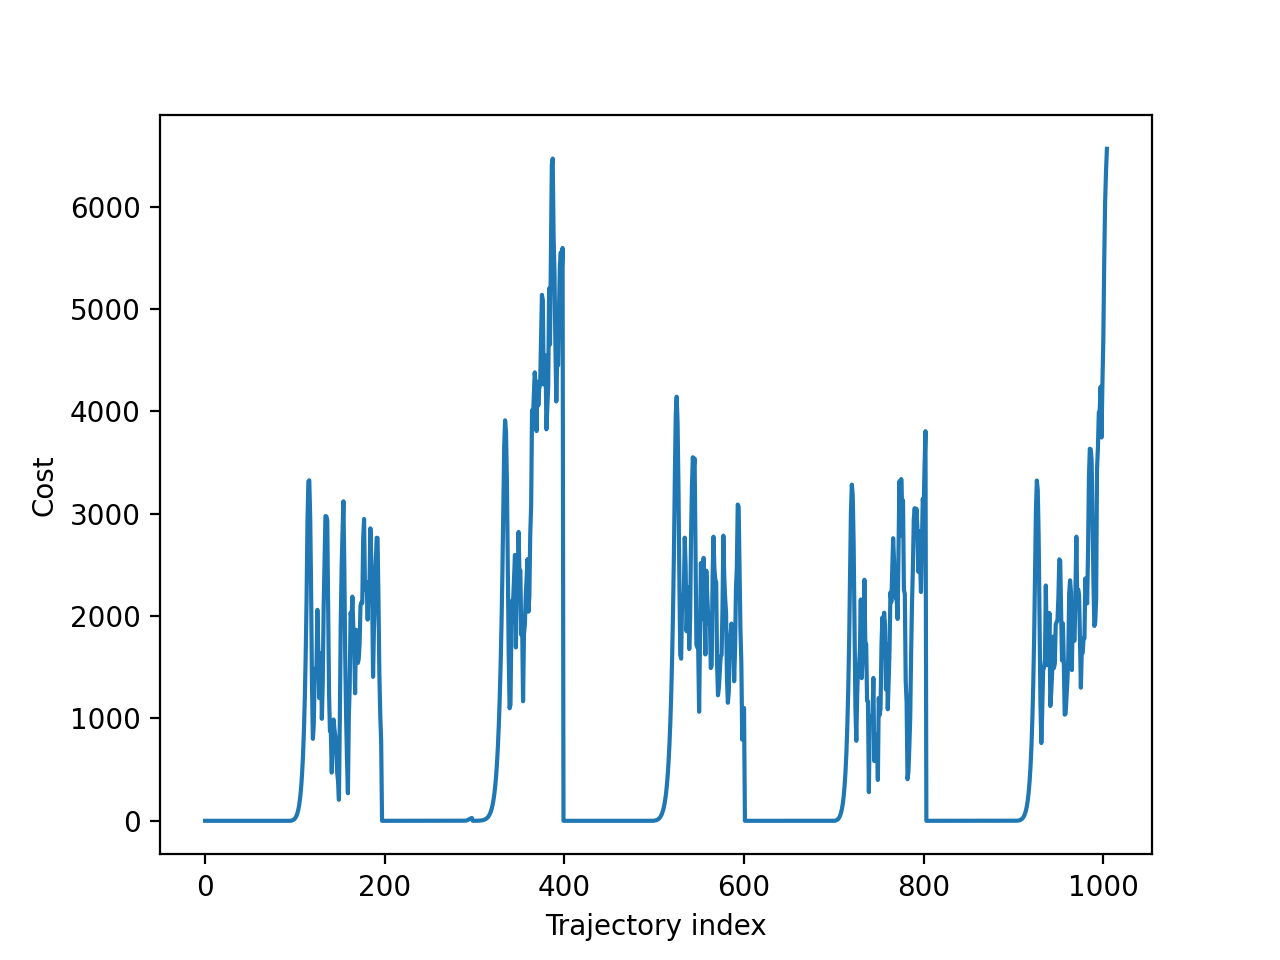

Text(0, 0.5, 'Cost')

In [23]:
plt.figure()
plt.plot(cost_traj)
plt.xlabel("Trajectory index")
plt.ylabel("Cost")

## Define model parameters and train

In [24]:
# Load model parameters using yaml file
import ruamel.yaml as yaml

with open(r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/params.yaml") as f:
        yaml_data = yaml.load(f, Loader=yaml.RoundTripLoader)

num_hidden = yaml_data['num_hidden']
batch_size = yaml_data['batch_size']
learning_rate = yaml_data['learning_rate']
num_epochs = yaml_data['num_epochs']
model_save = yaml_data['save_path']

In [25]:
model = MLP(num_hidden=num_hidden, num_outputs=1)
# Printing the model shows its attributes
print(model)

MLP(
    # attributes
    num_hidden = [500, 400, 200]
    num_outputs = 1
)


In [26]:
rng = jax.random.PRNGKey(427)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (batch_size, p))  # Batch size 64, input size p
# Initialize the model
params = model.init(init_rng, inp)

In [ ]:
# Run only if error in next cell
try:
    import optax
except ModuleNotFoundError: 
    !pip install --quiet optax
    import optax 

In [27]:
import optax # Run previous cell if optax not found
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.adam(learning_rate=learning_rate)

In [28]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [29]:
import torch.utils.data as data

train_data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
trained_model_state = train_model(model_state, train_data_loader, num_epochs=num_epochs)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>


100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 316.93it/s]


In [30]:
eval_model(trained_model_state, train_data_loader, batch_size)

Loss of the model: 0.00


In [19]:
!pip install tensorboard

In [26]:
trained_model = model.bind(trained_model_state.params)

### Save model

In [ ]:
save_checkpoint(trained_model_state, model_save, 0)

### Load model

In [14]:
trained_model_state = restore_checkpoint(model_state, model_save)

In [15]:
trained_model = model.bind(trained_model_state.params)

## Inference 

## Load inference data

In [27]:
import numpy as np

file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/uni_train-nonoise3.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
ref_traj = np.vstack(unicycle_data[1])
rdot_traj = np.vstack(unicycle_data[2])

print(actual_traj.shape)
print(ref_traj.shape)

(10100, 3)
(10100, 3)


Inputs [array([ 0.00000000e+00, -1.04308128e-06]), array([0.07146093, 0.0047635 ]), array([0.16896725, 0.00506875]), array([0.26891212, 0.00466342]), array([0.37144985, 0.00360702]), array([0.47674715, 0.00196765]), array([ 5.85010850e-01, -1.45615637e-04]), array([ 0.69644455, -0.00262637]), array([ 0.8112837 , -0.00533419]), array([ 0.92977805, -0.00809552]), array([ 1.05219115, -0.0107047 ]), array([ 1.17876792, -0.01291772]), array([ 1.30976535, -0.0144253 ]), array([ 1.44537262, -0.01487233]), array([ 1.58571003, -0.01382562]), array([ 1.73074968, -0.01076339]), array([ 1.88023548, -0.00508326]), array([2.03355809, 0.00393815]), array([2.189574  , 0.01713087]), array([2.34633826, 0.03543858]), array([2.50079924, 0.05989271]), array([2.6482979, 0.0915918]), array([2.78196077, 0.13157884]), array([2.89202518, 0.18071469]), array([2.96492173, 0.23938484]), array([2.98255732, 0.30712241]), array([2.92187576, 0.38204216]), array([2.75538799, 0.4601864 ]), array([2.45356634, 0.53492802]

Loss of the model: 49159172.00


<IPython.core.display.Javascript object>


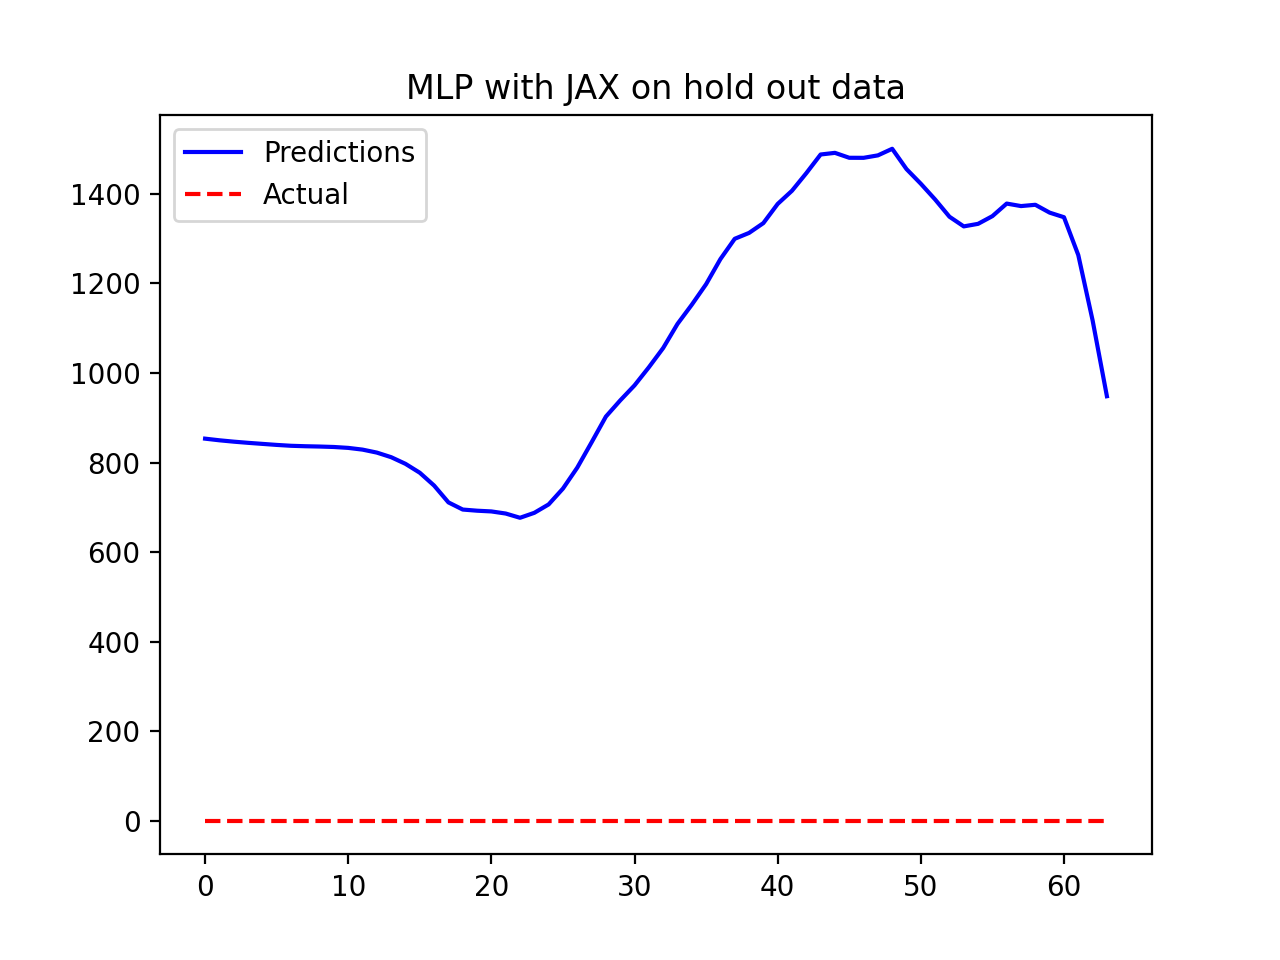

Text(0.5, 1.0, 'MLP with JAX on hold out data')

In [28]:
import torch.utils.data as data

Tstart=0
Tend=traj_len-300

N = 5
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]

# ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
# actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])

Kp = 5 * np.array([[2, 0, 0], [0, 1, 0]])
#key = jax.random.PRNGKey(793)
#Kd = 50 * jax.random.uniform(key=key, shape=(2, 3))

cost_traj, input_traj = compute_tracking_cost(ref_traj, actual_traj, rdot_traj, Kp, N, horizon)

aug_state = [np.append(actual_traj[r, :], ref_traj[r:r+N, :]) for r in range(len(ref_traj)-N)]
aug_state = np.array(aug_state)

test_dataset = TrajDataset(aug_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_state[Tstart+1:Tend, :].astype('float64'))
test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)
eval_model(trained_model_state, test_data_loader, batch_size)

data_input, _, cost, _ = next(iter(test_data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
plt.figure()
plt.plot(out.ravel(), 'b-', label="Predictions")
plt.plot(cost.ravel(), 'r--', label="Actual")
plt.legend()
plt.title("MLP with JAX on hold out data")

### Inference on the test data

In [29]:
out = []
true = []
for batch in test_data_loader:
    data_input, _, cost, _ = batch
    out.append(trained_model(data_input))
    true.append(cost)

In [30]:
out = np.vstack(out)
true = np.vstack(true)

<IPython.core.display.Javascript object>


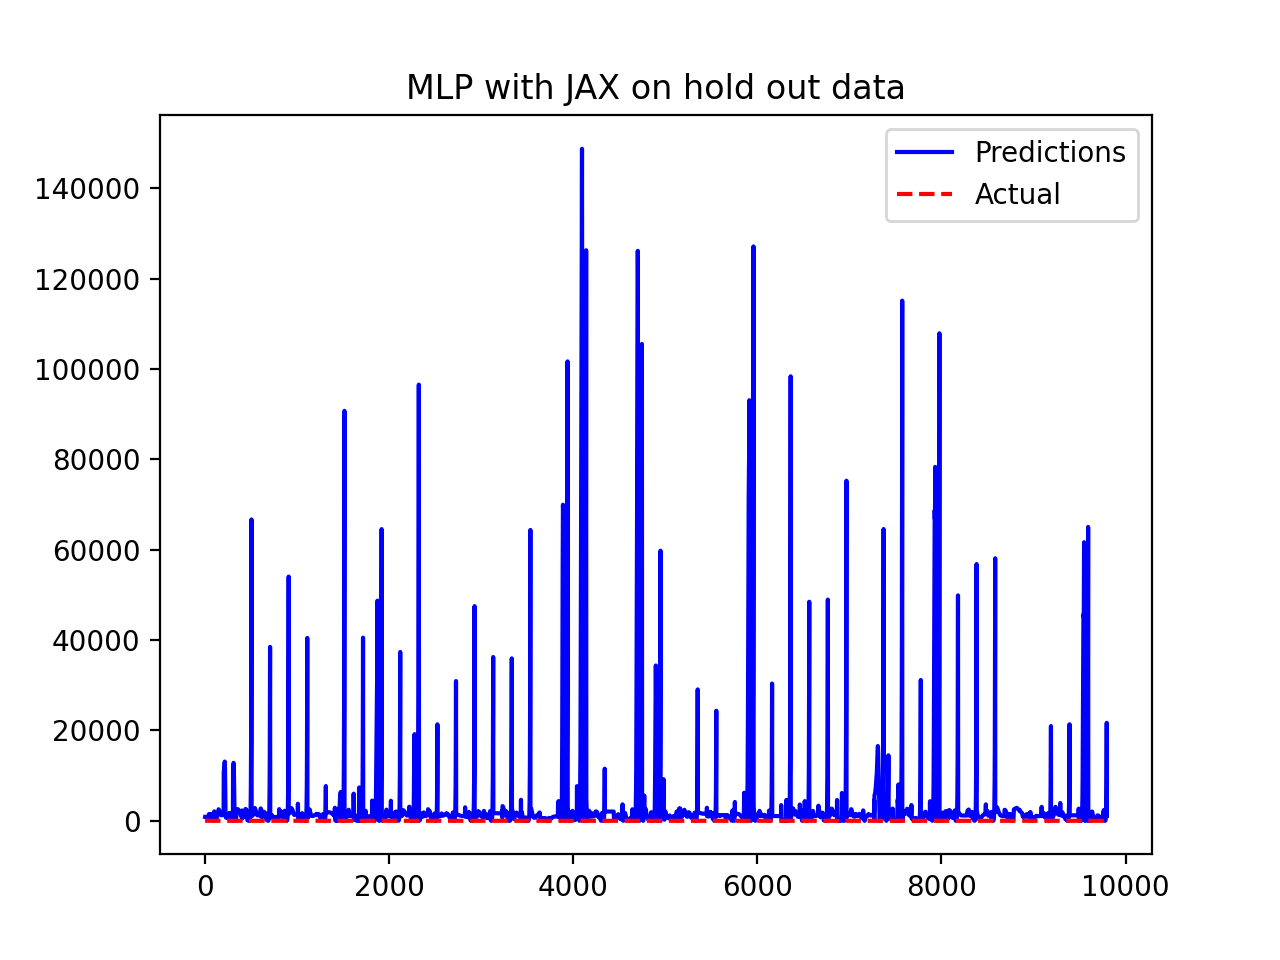

Text(0.5, 1.0, 'MLP with JAX on hold out data')

In [31]:
plt.figure()
plt.plot(out.ravel(), 'b-', label="Predictions")
plt.plot(true.ravel(), 'r--', label="Actual")
plt.legend()
plt.title("MLP with JAX on hold out data")

## Test time

### Optimize over the trajectories in the test dataset

In [39]:
from model_learning import test_model

data_state, _, data_cost, _ = next(iter(test_data_loader))
print(data_state[0])
print(data_cost[0])
jax_sol, solution, data = test_model(trained_model_state, test_data_loader, batch_size)

[0.80659175 0.3132937  2.14963436 0.80659175 0.31329373 0.
 0.81363493 0.3203437  0.         0.82083946 0.32745633 0.
 0.82820523 0.33463162 0.         0.8357324  0.34186959 0.        ]
[[7.39611669]]
Shape of data (18,)


/home/anusha/.local/lib/python3.8/site-packages/jaxopt/_src/lbfgs.py:127: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  fun = lambda leaf: jnp.zeros((history_size,) + leaf.shape, dtype=leaf.dtype)


Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)
Shape of data (18,)


1.0436601e-10
init [ 1.4444368 -1.0257452  2.926608 ]
New ref [[ 1.4444368  -1.0257452   2.926608  ]
 [ 0.9380885  -0.47495708  2.3620424 ]
 [ 0.91550195 -0.3334142   2.9669476 ]
 [ 1.0433648   0.07008833  2.9848952 ]
 [ 1.4919821  -0.30251557  3.7370827 ]]
rollout [[ 1.44443679 -1.02574515  2.92660809]
 [ 1.46036166 -1.02922249  2.95587417]
 [ 1.44619213 -1.02656027  3.04085608]
 [ 1.43726978 -1.02565841  3.04695453]
 [ 1.46287227 -1.02808864  3.03132504]]
4.54958e-09
init [ 1.727521  -1.0597883  3.147988 ]
New ref [[ 1.727521   -1.0597883   3.147988  ]
 [ 1.0320221  -0.5320002   2.534045  ]
 [ 1.0510243  -0.38804513  3.202848  ]
 [ 1.1998546   0.00987448  3.2978294 ]
 [ 1.5523223  -0.44761997  4.1569066 ]]
rollout [[ 1.72752094 -1.05978835  3.14798808]
 [ 1.74472767 -1.0596783   3.17946796]
 [ 1.70997733 -1.06099511  3.27523796]
 [ 1.68782828 -1.06397298  3.28447744]
 [ 1.70444256 -1.06158276  3.26176057]]
1.727782e-10
init [ 2.024763  -1.0871613  3.2571359]
New ref [[ 2.024763   -1.

rollout [[2.3368783  0.13611445 2.2696085 ]
 [2.34587899 0.12540266 2.29230458]
 [2.29706285 0.18089195 2.30559057]
 [2.23437211 0.25027169 2.23024935]
 [2.18622253 0.31238182 2.23157225]]
5.2429268e-12
init [1.7277397  0.13366418 2.741427  ]
New ref [[ 1.7277397   0.13366418  2.741427  ]
 [ 0.85398555  0.31482035  2.4088943 ]
 [ 0.7020664   0.5810616   2.91871   ]
 [ 1.2295862   0.08829342  2.4642746 ]
 [ 1.1564931  -0.1929314   2.3602586 ]]
rollout [[1.72773969 0.13366418 2.74142694]
 [1.7419154  0.12766801 2.76884121]
 [1.67427442 0.15411779 2.83756458]
 [1.60661224 0.17534717 2.83323267]
 [1.57744855 0.18463639 2.91757182]]
6.178896e-11
init [1.4562749 0.1697209 3.1570766]
New ref [[ 1.4562749   0.1697209   3.1570766 ]
 [ 0.646315    0.28876358  2.6009815 ]
 [ 0.53948754  0.67582554  2.973966  ]
 [ 1.2348361  -0.09063943  2.687882  ]
 [ 1.2147592  -0.17177114  2.685482  ]]
rollout [[1.45627487 0.1697209  3.1570766 ]
 [1.4708604  0.16994676 3.18864736]
 [1.40101591 0.16665783 3.2968

rollout [[ 1.68585253  1.01831162 -0.59971368]
 [ 1.69259622  1.01370084 -0.60571082]
 [ 1.71502298  0.99816912 -0.57924103]
 [ 1.81447201  0.93312108 -0.78524233]
 [ 1.89249772  0.85511968 -0.86075769]]
3.7748948e-06
init [ 1.7001641   1.0271816  -0.59448934]
New ref [[ 1.7001641   1.0271816  -0.59448934]
 [ 1.8219192   0.4930433  -0.6414858 ]
 [ 0.77030987  0.6277575   0.97892356]
 [ 0.66636366  1.0276853  -0.3294899 ]
 [ 1.3369406   0.5559507  -0.9117712 ]]
rollout [[ 1.70016408  1.02718163 -0.59448934]
 [ 1.70706631  1.02251519 -0.60043423]
 [ 1.72953771  1.00712734 -0.57421776]
 [ 1.82856984  0.94305997 -0.77843122]
 [ 1.90654835  0.8661605  -0.85329859]]
1.1552031e-06
init [ 1.7165629  1.0378702 -0.594493 ]
New ref [[ 1.7165629   1.0378702  -0.594493  ]
 [ 1.8384805   0.50379574 -0.64146596]
 [ 0.78705436  0.6385853   0.9788812 ]
 [ 0.68327874  1.0385425  -0.32948574]
 [ 1.3540196   0.56688905 -0.9117544 ]]
rollout [[ 1.71656287  1.03787017 -0.59449297]
 [ 1.72352797  1.03316118 

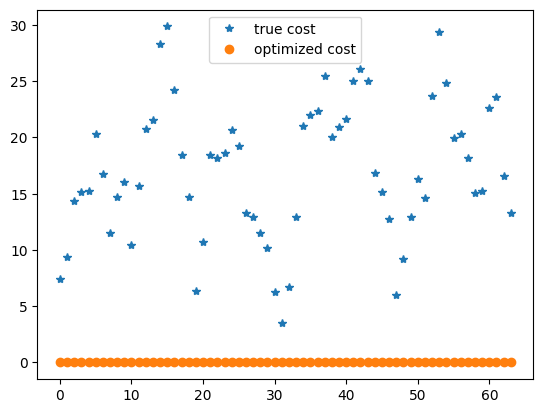

In [40]:
from helper_functions import forward_simulate

cost = []
reg_cost = []
rollout = []
ref = []

i = 0
for sol in solution:
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    print(sol.state.value)
    reg_cost.append(sol.state.value)
    new_aug_state = sol.params
    x0 = new_aug_state[0:3]
    print("init", x0)
    ref.append(new_aug_state.reshape([N, 3]))
    print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], N)
    cost.append(c)
    rollout.append(x)
    print("rollout", x)
    i += 1
    
plt.figure()
plt.plot(data_cost.ravel(), '*', label="true cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.legend()

In [41]:
ref = np.vstack(ref)
print(ref.shape)

(320, 3)


In [42]:
new_data = np.vstack(data)
print(new_data.shape)

(64, 18)


[ 1.4444368 -1.0257452  2.926608 ]
[0.80659175 0.3132937  2.14963436 0.80659175 0.31329373 0.
 0.81363493 0.3203437  0.         0.82083946 0.32745633 0.
 0.82820523 0.33463162 0.         0.8357324  0.34186959 0.        ]


Text(0, 0.5, 'y position')

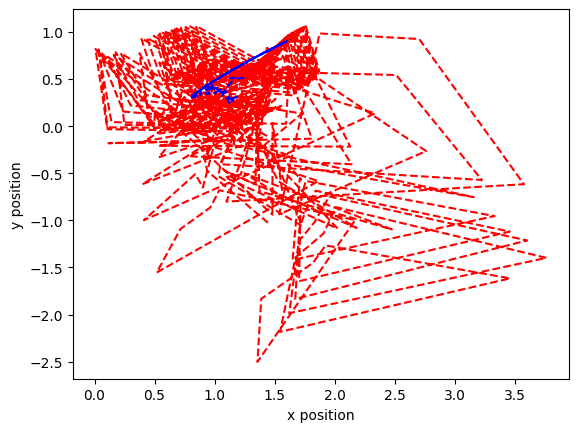

In [46]:
plt.figure()
m = 0
print(ref[m])
print(data[m])

plt.plot(ref[:, 0], ref[:, 1], 'r--')
plt.plot(new_data[:, 0::3], new_data[:, 1::3], 'b--')
plt.xlabel("x position")
plt.ylabel("y position")

## Evaluate on polynomial trajectories and ilqr


In [32]:
from generate_data import generate_polynomial_trajectory
import numpy as np
import jax.numpy as jnp

num_inf = 100
inits = np.random.randint(0, 2, (2, num_inf))
inits = np.append(inits, np.zeros(num_inf))
inits = np.reshape(inits, (3, num_inf))

goals = np.random.randint(1, 3, (2, num_inf))
goals = np.append(goals, np.zeros(num_inf))
goals = np.reshape(goals, (3, num_inf))

N = 5

# uni_ilqr1 = ILQR(unicycle, maxiter=1000)

poly_traj = []
for i in range(num_inf):
    poly_traj.append(generate_polynomial_trajectory(inits[:, i], goals[:, i], N, 2))
    # ilqr_traj.append()
    
print(poly_traj[0].shape)

poly_aug_state = [np.append(poly_traj[r][0, :], poly_traj[r]) for r in range(len(poly_traj))]
poly_aug_state = jnp.array(poly_aug_state)
print(poly_aug_state.shape)

(5, 3)
(100, 18)


In [39]:
from model_learning import gradient_descent, calculate_cost, gradient_descent_with_line_search
from jax.scipy.optimize import minimize
from jaxopt import LBFGS
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_affine_set

pg = ProjectedGradient(calculate_cost, projection=projection_affine_set)
A = np.zeros((2, N))
A[0, 0] = 1
A[-1, -1] = 1

#pg_sol = pg.run(w_init, data=(X, y)).params

solution = []
solution2 = []
for i in range(3):
    solution.append(gradient_descent(calculate_cost, poly_aug_state[i, 3:], poly_aug_state[i, :3], poly_aug_state[i, -3:], 
                    trained_model_state, trained_model_state.params, poly_aug_state[i, 3:]))
    GD = LBFGS(calculate_cost)
    solution2.append(GD.run(poly_aug_state[i, 3:], poly_aug_state[i, :3], poly_aug_state[i, -3:], 
                    trained_model_state, trained_model_state.params))
    
    #solution2.append(pg.run(poly_aug_state[i, 3:], 
    #                        hyperparams_proj=(A, np.array([poly_aug_state[i, 0:3], poly_aug_state[i, -3:]]))))
    
    #solution2.append(gradient_descent_with_line_search(calculate_cost, poly_aug_state[i, 3:], poly_aug_state[i, :3], poly_aug_state[i, -3:], 
    #                trained_model_state, trained_model_state.params, poly_aug_state[i, 3:]))
    
    # solution2.append(minimize(calculate_cost, poly_aug_state[i, 3:], 
    #    args=(poly_aug_state[i, :3], poly_aug_state[i, -3:], trained_model_state, trained_model_state.params), method="BFGS"))
    

In [40]:
print(solution2[0].params)

[ 0.09115206 -0.43453524  0.33706608  0.70501757  0.12016661  0.01208912
  1.2908038   0.57313    -0.143121    1.7405896   1.2448792  -0.51026773
  2.438322    1.7179708  -0.4234093 ]


<IPython.core.display.Javascript object>


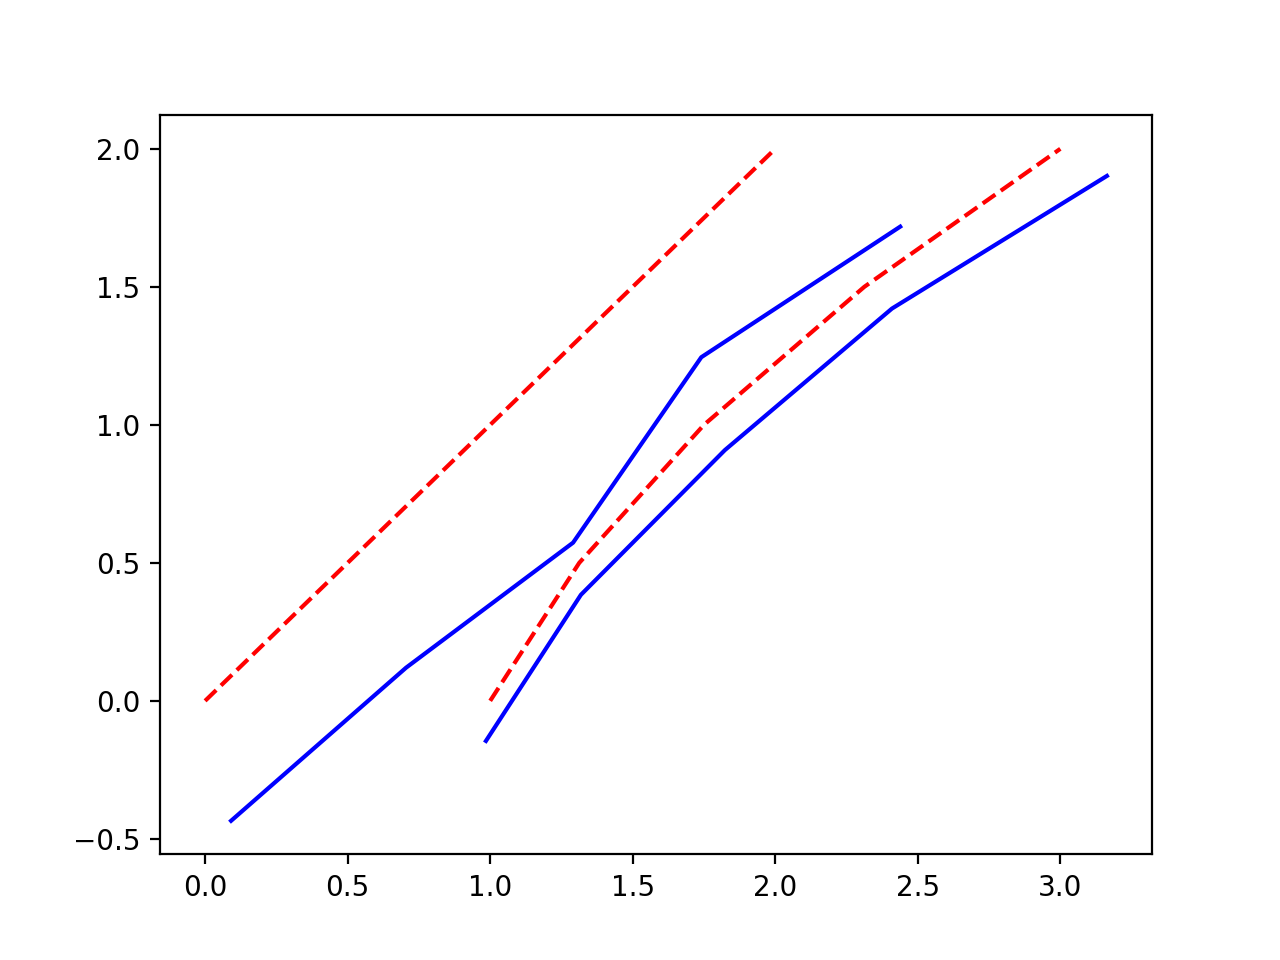

In [49]:
plt.figure()

for i in range(2):
    plt.plot(solution2[i].params[0::3], solution2[i].params[1::3], 'b-')
    #plt.plot(ref[i][:, 0], ref[i][:, 1], 'g-', label='opt2')
    plt.plot(poly_traj[i][:, 0], poly_traj[i][:, 1], 'r--')

init [ 0.09115206 -0.43453524  0.33706608]
New ref [[ 0.09115206 -0.43453524  0.33706608]
 [ 0.70501757  0.12016661  0.01208912]
 [ 1.2908038   0.57313    -0.143121  ]
 [ 1.7405896   1.2448792  -0.51026773]
 [ 2.438322    1.7179708  -0.4234093 ]]
rollout [[ 0.09115206 -0.43453524  0.33706608]
 [ 0.09060765 -0.43472602  0.34043674]
 [ 0.01318286 -0.46215207  0.36206515]
 [-0.14151715 -0.52074662  0.38464775]
 [-0.37852099 -0.61668863  0.42550111]]
init [ 0.9851506  -0.14516115 -0.11470928]
New ref [[ 0.9851506  -0.14516115 -0.11470928]
 [ 1.3182569   0.3841976  -0.18949586]
 [ 1.823298    0.90844154 -0.29745477]
 [ 2.4093902   1.421186   -0.4194768 ]
 [ 3.1633873   1.9017289  -0.436042  ]]
rollout [[ 0.98515058 -0.14516115 -0.11470928]
 [ 0.99503808 -0.14630034 -0.11585637]
 [ 0.94915107 -0.14096012 -0.1332303 ]
 [ 0.82722116 -0.12461856 -0.16404126]
 [ 0.61603725 -0.08966156 -0.20721092]]
init [-124.85844  -19.58611  240.8083 ]
New ref [[-124.85844    -19.58611    240.8083   ]
 [ -49.6

<IPython.core.display.Javascript object>


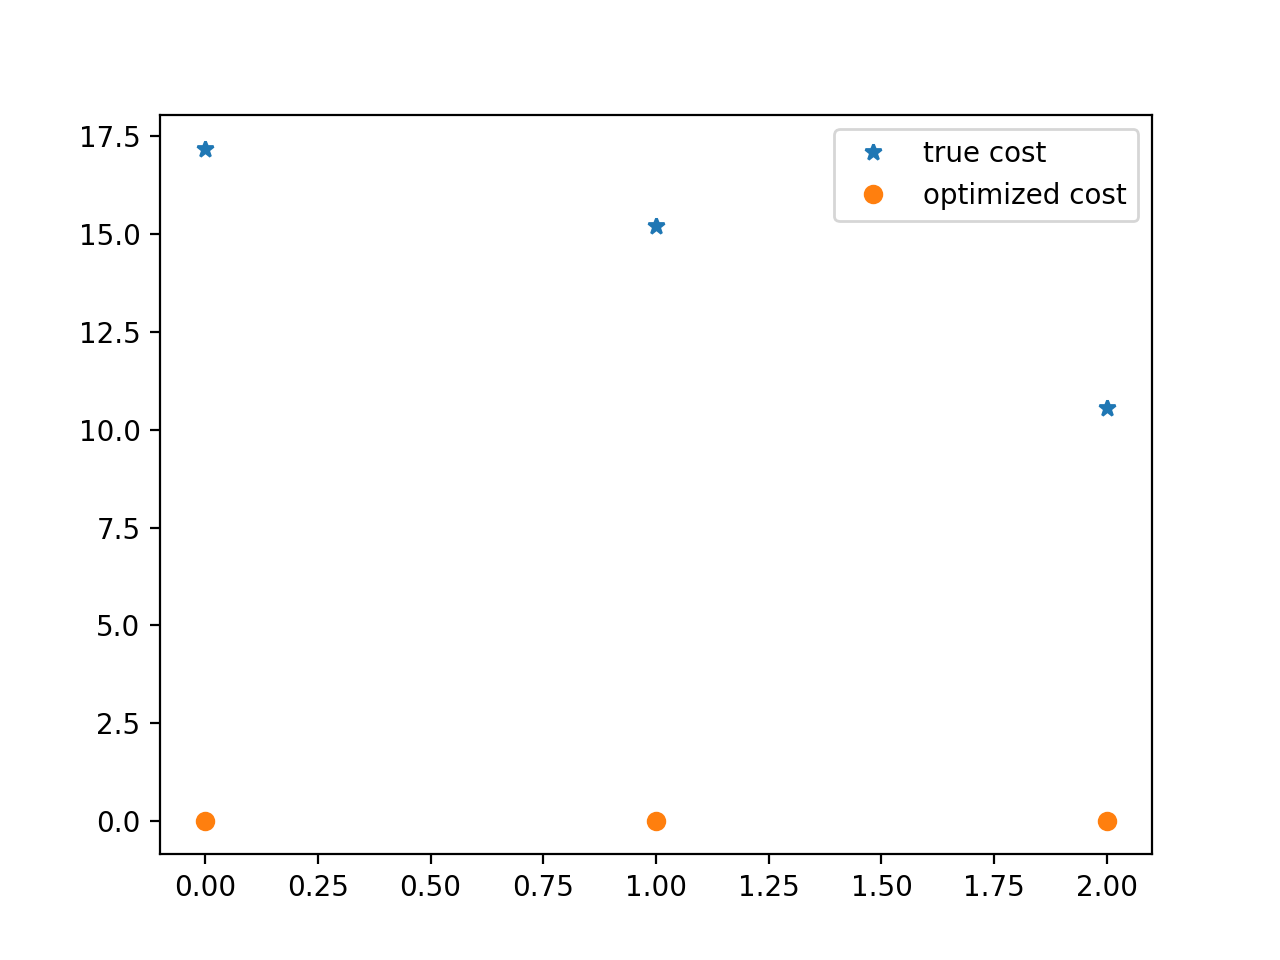

In [46]:
from generate_data import forward_simulate

cost = []
reg_cost = []
rollout = []
ref = []

i = 0
for sol in solution2:
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    reg_cost.append(sol.state.value)
    new_aug_state = sol.params
    x0 = new_aug_state[0:3]
    print("init", x0)
    ref.append(new_aug_state.reshape([N, 3]))
    print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], N)
    cost.append(c)
    rollout.append(x)
    print("rollout", x)
    i += 1
    
plt.figure()
plt.plot(poly_cost, '*', label="true cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.legend()

In [45]:
print(solution)

[DeviceArray([0.9895245 , 0.99761105, 0.15315244, 1.270803  , 1.0573907 ,
             0.104464  , 1.7374961 , 1.2314272 , 0.1505105 , 2.2875876 ,
             1.5148616 , 0.15788655, 2.9540257 , 1.9813128 , 0.16022299],            dtype=float32), DeviceArray([-3.1133296e-04,  1.8872030e-02, -4.5619380e-02,
              2.7006650e-01,  5.1453817e-01, -3.3984169e-02,
              4.9745101e-01,  1.0048804e+00, -4.3190714e-02,
              7.4614954e-01,  1.4898112e+00, -4.4955004e-02,
              9.8835266e-01,  1.9894595e+00, -5.2838802e-02],            dtype=float32), DeviceArray([ 0.01108708,  0.00850977, -0.00886909,  0.5239247 ,
              0.25481218, -0.00639153,  1.0011003 ,  0.5001019 ,
             -0.00863023,  1.4918234 ,  0.7409198 , -0.0088453 ,
              1.9817169 ,  0.99424696, -0.00900054], dtype=float32)]


init [-7.88915315e-16 -7.88915315e-16  0.00000000e+00]
goal [2. 2. 0.]
New ref [[-7.88915315e-16 -7.88915315e-16  0.00000000e+00]
 [ 5.74616528e+00 -1.02927990e+01 -4.38060331e+00]
 [ 8.34414196e+00 -1.02865801e+01 -1.04765615e+01]
 [ 8.05722618e+00 -5.62787533e+00 -2.13637733e+01]
 [ 2.00000000e+00  2.00000000e+00  0.00000000e+00]]
rollout [[-7.88915315e-16 -7.88915315e-16  0.00000000e+00]
 [-7.96804468e-16 -7.88915315e-16  0.00000000e+00]
 [-2.51494408e-03 -7.88915315e-16  1.12792450e+00]
 [-1.64296236e-01 -3.41099396e-01  3.27816086e+00]
 [ 4.59811583e-01 -2.55332222e-01  7.02515182e+00]]
init [ 1.00000000e+00 -7.88915315e-16  0.00000000e+00]
goal [3. 2. 0.]
New ref [[ 1.00000000e+00 -7.88915315e-16  0.00000000e+00]
 [ 1.55604458e+00 -4.30162477e+00 -8.50791645e+00]
 [ 4.89849091e+00 -2.69989538e+00 -1.37552052e+01]
 [ 7.06975269e+00 -1.64657784e+00 -1.93368912e+01]
 [ 3.00000000e+00  2.00000000e+00  0.00000000e+00]]
rollout [[ 1.00000000e+00 -7.88915315e-16  0.00000000e+00]
 [ 1.01

<IPython.core.display.Javascript object>


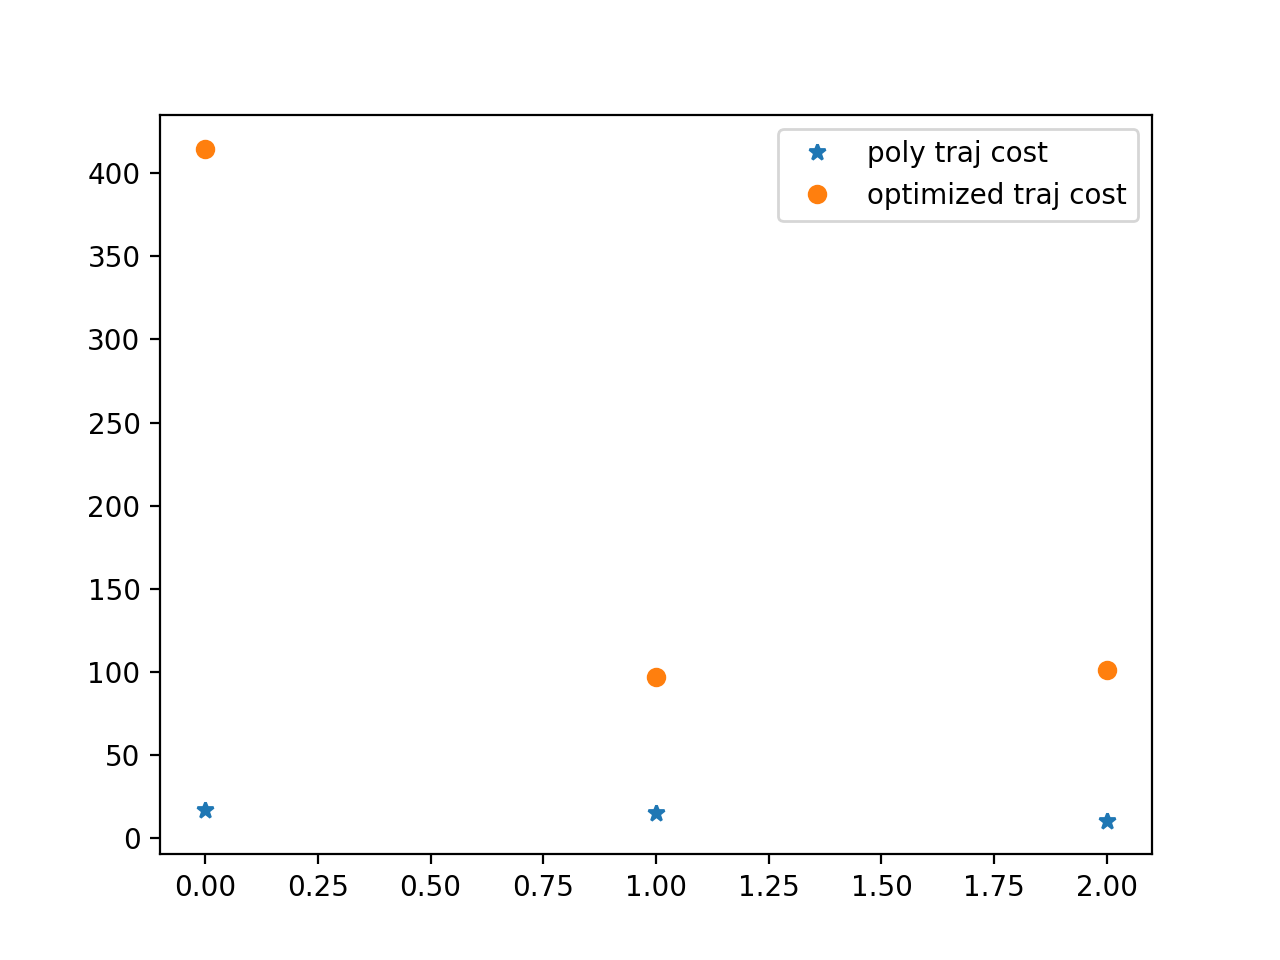

In [38]:
from generate_data import forward_simulate

cost = []
rollout = []
poly_cost = []
poly_rollout = []
ref = []

for i in range(3): 
    x0 = poly_traj[i][0, :]
    print("init", x0)
    goal = poly_traj[i][-1, :]
    print("goal", goal)
    new_aug_state = np.append(x0, solution[i][3:-3])
    new_aug_state = np.append(new_aug_state, goal)
    ref.append(new_aug_state.reshape([N, 3]))
    
    print("New ref", ref[i])
    c, x = forward_simulate(x0, ref[i], N)
    c_poly, x_poly = forward_simulate(x0, poly_traj[i], N)
    cost.append(c)
    poly_cost.append(c_poly)
    rollout.append(x)
    poly_rollout.append(x_poly)
    print("rollout", x)
    
print("Poly", np.mean(poly_cost))
print("Opt", np.mean(cost))
    
plt.figure()
plt.plot(poly_cost, '*', label="poly traj cost")
plt.plot(cost, 'o', label="optimized traj cost")
plt.legend()

In [38]:
from model_learning import calculate_cost
from jax.scipy.optimize import minimize

solution = []
for i in range(3):
    solution.append(minimize(calculate_cost, poly_aug_state[i, 3:], 
        args=(poly_aug_state[i, :3], poly_aug_state[i, -3:], trained_model_state, trained_model_state.params), method="BFGS"))
    

In [43]:
# How to parse the solution at test time?
# from helper_functions import forward_simulate

cost = []
reg_cost = []
rollout = []
ref = []

i = 0
for sol in solution:
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    reg_cost.append(sol.fun)
    new_aug_state = sol.x
    x0 = new_aug_state[0:3]
    print("init", x0)
    ref.append(new_aug_state.reshape([N, 3]))
    print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], Kp, Kd, N)
    cost.append(c)
    rollout.append(x)
    print("rollout", x)
    i += 1
    
plt.figure()
plt.plot(data_cost.ravel(), '*', label="true cost")
plt.plot(reg_cost, 'o', label="optimized cost")
plt.legend()

AttributeError: 'DeviceArray' object has no attribute 'fun'

<IPython.core.display.Javascript object>


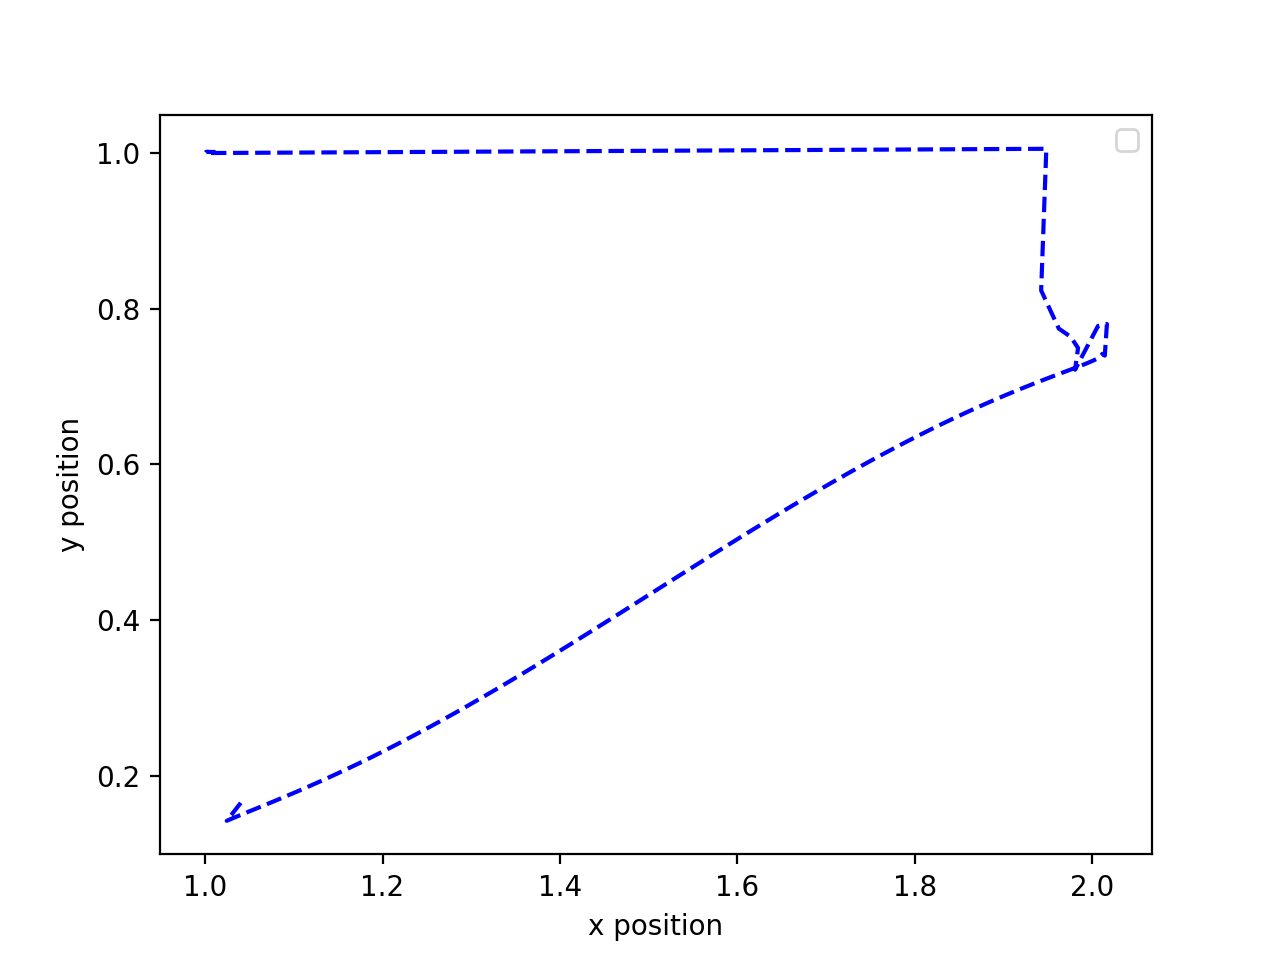

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan 

In [39]:
plt.figure()
m = 0
print(ref[m])
print(data[m])
# plt.plot(ref[0:10, 0], ref[0:10, 1], 'r--', label="new ref")
plt.plot(new_data[0, 0::3], new_data[0, 1::3], 'b--')
plt.xlabel("x position")
plt.ylabel("y position")
plt.legend()

In [ ]:
print(solution[0].fun)
print(solution[0].x)

In [5]:
import jax.numpy as np
from jax import grad, jit
from functools import partial

def line_search(func, alpha=0.1, beta=0.5, max_iters=100):
    # Initialize step size as 1
    t = 1.0

    # Perform line search
    for i in range(max_iters):
        # Evaluate the function and gradient at the current parameters
        f = func(data_state, init, goal, state, params)
        grad_f = grad_func(data_state, init, goal, state, params)

        # Update parameters in the search direction
        next_ref = ref + t * direction

        # Check the Armijo condition
        if func(next_ref, init, goal, state, params) > f + alpha * t * jnp.dot(grad_f, direction):
            t *= beta
        else:
            return t

def gradient_descent_with_line_search(func, init_params, learning_rate=0.01, num_iters=100):
    # Define the gradient of the function using JAX's `grad` function
    grad_func = grad(func)

    # Define a JIT-compiled version of the gradient descent update step
    #@partial(jit, static_argnums=[0])
    @jit
    def update(params):
        gradient = grad_func(params)
        direction = -gradient
        success = line_search(func, grad_func, params, direction)
        # step_size = np.where(success == 1, learning_rate, 0.0)
        step_size = 1
        return params + step_size * direction

    # Perform gradient descent by iteratively updating the parameters
    params = np.asarray(init_params)
    for i in range(num_iters):
        params = update(params)
    
    return params

# Example usage
def my_func(params):
    return np.sum(params**2)

init_params = np.array([1.0, 2.0])
optimized_params = gradient_descent_with_line_search(my_func, init_params)
print(optimized_params)


TypeError: line_search() missing 5 required positional arguments: 'state', 'params', 'grad_func', 'ref', and 'direction'

In [82]:
import jax.numpy as jnp
from jax import grad
from jaxopt import projection
from jaxopt import optimizers

def projected_gradient_descent(func, init_params, projection_fn, step_size=0.01, num_iters=100):
    # Define the gradient of the function using JAX's `grad` function
    grad_func = grad(func)

    # Define the `opt_init` and `opt_update` functions using the `optimizers` module
    opt_init, opt_update, get_params = optimizers.sgd(step_size=step_size)
    
    # Initialize the optimizer state using `opt_init`
    opt_state = opt_init(init_params)

    # Perform projected gradient descent by iteratively updating the parameters
    for i in range(num_iters):
        # Get the current parameters from the optimizer state using `get_params`
        params = get_params(opt_state)

        # Compute the gradient of the function at the current parameters
        grad_params = grad_func(params)

        # Project the gradient onto the feasible set using the projection function
        grad_params_proj = projection_fn(params, grad_params)

        # Update the optimizer state using `opt_update`
        opt_state = opt_update(i, grad_params_proj, opt_state)

    # Return the optimized parameters
    return get_params(opt_state)

# Example usage
def my_func(params):
    return jnp.sum(params**2)

init_params = jnp.array([1.0, 2.0])
projected_params = projection.box(np.asarray([-1.0, -1.0]), np.asarray([1.0, 1.0]))
optimized_params = projected_gradient_descent(my_func, init_params, projected_params)
print(optimized_params)


ImportError: cannot import name 'optimizers' from 'jaxopt' (/home/anusha/.local/lib/python3.8/site-packages/jaxopt/__init__.py)

In [84]:
import jax.numpy as jnp
from jax import grad, lax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax

def my_func(params):
    return jnp.sum(params**2)

init_params = jnp.array([1.0, 2.0])
max_step_size = 1.0
min_step_size = 1e-5
num_iters = 100
tolerance = 1e-5

def update(params, step_size):
    grad_params = grad(my_func)(params)
    new_params = params - step_size * grad_params
    return new_params

opt_init, opt_update, get_params = optimizers.sgd(step_size=0.1)
opt_update = jit(opt_update)

params = init_params
for i in range(num_iters):
    step_size = max_step_size
    loss = my_func(params)
    grad_loss = jnp.dot(grad(my_func)(params), grad(my_func)(params))

    def while_cond_fn(carry):
        i, params, step_size, loss = carry
        return (i < 20) & (loss >= my_func(update(params, step_size)))

    def while_body_fn(carry):
        i, params, step_size, loss = carry
        new_params = update(params, step_size)
        new_loss = my_func(new_params)
        new_grad_loss = jnp.dot(grad(my_func)(new_params), grad(my_func)(new_params))
        step_size = step_size / 2.0
        return (i + 1, params, step_size, loss), (new_params, new_loss, new_grad_loss)

    (i, params, step_size, loss), (params, loss, grad_loss) = lax.while_loop(
        while_cond_fn, while_body_fn, (0, params, step_size, loss))

    params = opt_update(i, grad(my_func)(params), opt_init(params))[0]

optimized_params = get_params(params)
print(optimized_params)


ModuleNotFoundError: No module named 'jax.experimental.optimizers'

## Visualization plots code

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(np.dstack([out, cost]).reshape([64, 2]), columns=['preds', 'actual'])

order=['preds', 'actual']
x = "Evaluation on Training"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
plt.figure()
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
axes.set_ylim((0, 10))
# plt.savefig('/home/anusha/Downloads/icra_results/train.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

data_input, _, cost, _ = next(iter(train_data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
plt.figure()
plt.plot(out.ravel(), 'o', label="Predictions")
plt.plot(cost.ravel(), 'o', label="Actual")
plt.legend()
plt.title("MLP with JAX on training data")

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(np.dstack([np.vstack(out), np.vstack(true)]).reshape([499, 2]), columns=['preds', 'actual'])

order=['preds', 'actual']
x = "Evaluation on Hold Out Data"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
plt.figure()
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
axes.set_ylim((0, 10))
# plt.savefig('/home/anusha/Downloads/icra_results/train.png', dpi=300, bbox_inches='tight')
plt.show()

[80.22324387862642, 321.09662825302235, 327.7639865545761, 80.22324387862642, 95.55581835629299, 114.82971701111025, 321.09662825302235, 327.7639865545761, 80.22324387862642, 12.935666186613066, 114.82971701111025, 126.86833102408806, 80.22324387862642, 12.935666186613066, 24.544342099707574, 91.1660362416075, 154.40123858703524, 29.413109299456316, 154.40123858703524, 321.09662825302235, 29.413109299456316, 291.82206404403604, 296.7602138181224, 110.51226801073729, 91.1660362416075, 29.413109299456316, 80.22324387862642, 154.40123858703524, 126.86833102408806, 296.7602138181224, 80.22324387862642, 121.43268017942096, 29.413109299456316, 114.82971701111025, 95.55581835629299, 28.477304173203215, 91.1660362416075, 12.935666186613066, 121.43268017942096, 126.86833102408806, 291.82206404403604, 24.544342099707574, 291.82206404403604, 114.82971701111025, 80.22324387862642, 291.82206404403604, 327.7639865545761, 24.544342099707574, 291.82206404403604, 12.935666186613066, 24.544342099707574,

<IPython.core.display.Javascript object>


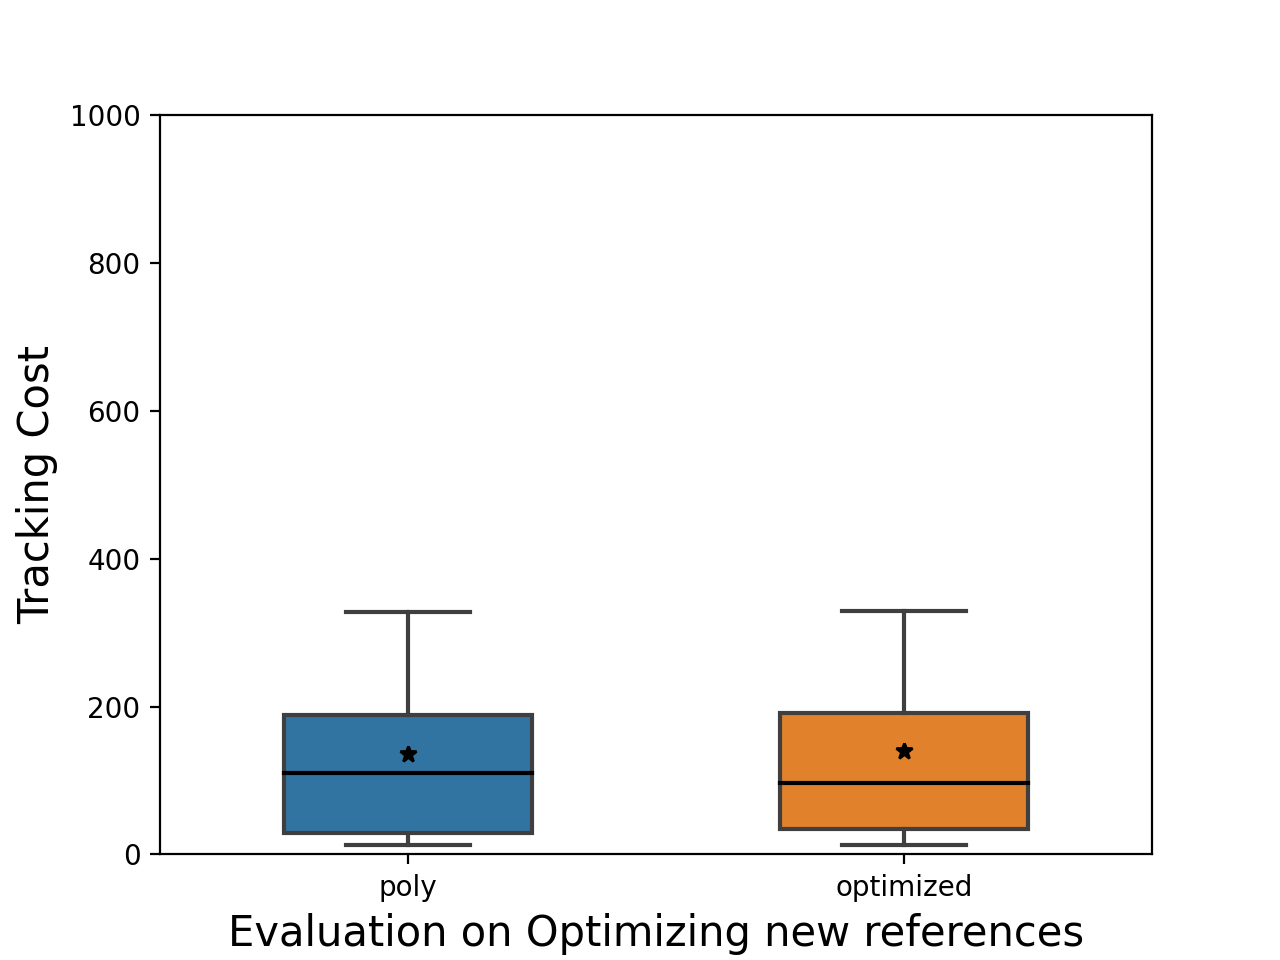

In [75]:
import pandas as pd
import seaborn as sns

print(poly_cost)

df = pd.DataFrame(np.dstack([poly_cost, cost]).reshape([100, 2]), columns=['poly', 'optimized'])

order=['poly', 'optimized']
x = "Evaluation on Optimizing new references"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
plt.figure()
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
axes.set_ylim((0, 1000))
# plt.savefig('/home/anusha/Downloads/icra_results/train.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df = pd.DataFrame(np.dstack(traj_costs).reshape([10, 2]), columns=['0.1', '10'])

order=['0.1', '10']
x = "Tracking Penalty (rho)"
y = "Tracking Cost"
#print(pd.melt(df))
flierprops = dict(marker='o', markerfacecolor='#FFFFFF', markersize=4,
                  linestyle='none', markeredgecolor='#D3D3D3')
axes = sns.boxplot(data=pd.melt(df, var_name=x, value_name=y), x=x, y=y, order=order, dodge=False, width=0.5, medianprops=dict(color='black'), 
                     # palette={labels[0]:"blue", labels[1]:"orange", labels[2]:"green", labels[3]:"red"}, saturation=1,
                      flierprops=flierprops,
                      showmeans=True, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"})
axes.set_xlabel(x, fontsize=15)
axes.set_ylabel(y, fontsize=15)
#axes.set_ylim((7, 9))
plt.savefig('/home/anusha/Downloads/icra_results/cost-rho-results.png', dpi=300, bbox_inches='tight')
plt.show()